In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, make_scorer
from statistics import mean
import numpy as np
import pandas as pd

In [2]:
X_test_full = pd.read_csv("./preprocessed/mergedTestData.csv")

scoring = {
  "precision_score": make_scorer(precision_score, zero_division=0),
  "recall_score": "recall",
  "roc_auc_score": "roc_auc",
  "f1_score": "f1",
  "accuracy_score": "accuracy",
}

def run_model(pipeline, param_grid, X_train, y_train, X_test):
  # Define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

  grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
    scoring=scoring, n_jobs=-1, cv=cv, refit="roc_auc_score")

  grid_result = grid.fit(X_train, y_train)
  print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

  # Evaluate the model
  p_pred = grid_result.predict_proba(X_test)

  # ROC Curve
  estimator = grid_result.best_estimator_
  RocCurveDisplay.from_estimator(estimator, X_train, y_train)
  PrecisionRecallDisplay.from_estimator(estimator, X_train, y_train)
  
  print("----------------- Metrics: -----------------")
  print("Mean Fit Time: " + str(mean(grid_result.cv_results_.get('mean_fit_time'))))
  print("Mean Score Time: " + str(mean(grid_result.cv_results_.get('mean_score_time'))))
  print("Mean Accuracy Score: " + str(mean(grid_result.cv_results_.get('mean_test_accuracy_score'))))
  print("Mean Precision Score: " + str(mean(grid_result.cv_results_.get('mean_test_precision_score'))))
  print("Mean Recall Score: " + str(mean(grid_result.cv_results_.get('mean_test_recall_score'))))
  print("Mean Roc-Auc Score: " + str(mean(grid_result.cv_results_.get('mean_test_roc_auc_score'))))
  print("Mean F1 Score: " + str(mean(grid_result.cv_results_.get('mean_test_f1_score'))))

  resultData = {'Id': X_test_full['loan_id'], 'Predicted': p_pred[:,0]}
  result = pd.DataFrame(data=resultData)
  return result

def encode_df(df):
  columnsToEncode = list(df.select_dtypes(include=['object']))
  le = LabelEncoder()
  for feature in columnsToEncode:
      try:
          df[feature] = le.fit_transform(df[feature])
      except:
          print('Error encoding ' + feature)
  return df

def load_data():
  X_train_full = pd.read_csv("./preprocessed/mergedTrainData.csv")

  # Obtain target and predictors
  # features = ["duration","payments","last_balance","itr_balance_per_account", "frequency", "region","ratio entrepeneurs","average salary ","unemploymant_growth","criminality_growth","age_group"]
  # features = ['reached_negative_balance', 'ratio_RAB', 'credit_ratio', 'withdrawal_ratio', 'IC_mean', 'balance_min', 'mean_trans_profit', 'balance_mean', 'ratio_CC', 'CC_std', 'ratio_IC', 'withdrawal_max', 'WC_max']
  features = ['reached_negative_balance', 'RAB_mean', 'ratio_RAB', 'credit_ratio', 'balance_min', 'RAB_sum', 'mean_trans_profit', 'balance_mean', 'ratio_CC', 'CC_std', 'IC_min', 'CC_max', 'ratio_IC', 'withdrawal_max', 'WC_max', 'last_balance', 'CAB_mean']

  X_train = X_train_full[features]
  X_test = X_test_full[features]

  # Positive class now is 1 and negative class now is -1
  X_train_full.loc[X_train_full["status"] == 1, "status"] = 0
  X_train_full.loc[X_train_full["status"] == -1, "status"] = 1

  y_train = X_train_full.status

  return [X_train, X_test, y_train]

## Logistic Regression
Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

------- WITH UNDERSAMPLING -------
Best: 0.875666 using {'classification__C': 0.5, 'classification__class_weight': None, 'classification__penalty': 'l2', 'classification__solver': 'newton-cg', 'under__sampling_strategy': 0.2}
----------------- Metrics: -----------------
Mean Fit Time: 0.05961379020933121
Mean Score Time: 0.03252040817624047
Mean Accuracy Score: 0.8251385688684075
Mean Precision Score: 0.4699948846541984
Mean Recall Score: 0.7157023809523809
Mean Roc-Auc Score: 0.8569960579910977
Mean F1 Score: 0.5232098726436962


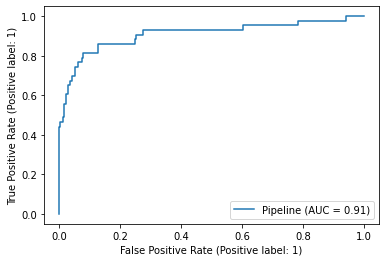

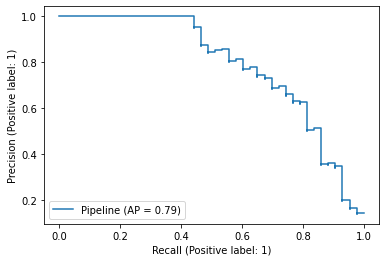

In [ ]:
# Load data
[X_train, X_test, y_train] = load_data()

X_train = encode_df(X_train)
X_test = encode_df(X_test)

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 0.99, 'majority'],
          'classification__penalty': ['l2'],
          'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
          'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
          'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/logisticRegressionUndersampling.csv", index=None)

In [ ]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
pipeline = Pipeline([('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

param_grid = {'classification__penalty': ['l2'],
          'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
          'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
          'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/logisticRegression.csv", index=None)


In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('scaler', StandardScaler()), ('classification', LogisticRegression(random_state=0, max_iter=10000))])

weights = list(np.linspace(0.2, 0.9, 10)) + ['minority', 'auto']
param_grid = {
        'smote__sampling_strategy': weights,
        'classification__penalty': ['l2'],
        'classification__C': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
        'classification__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
        'classification__class_weight': ["balanced", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/logisticRegressionWithSMOTE.csv", index=None)

# Random Forest

In [ ]:
# https://stackoverflow.com/questions/30814231/using-the-predict-proba-function-of-randomforestclassifier-in-the-safe-and-rig
# https://rpmcruz.github.io/machine%20learning/2018/02/09/probabilities-trees.html

# Load data
[X_train, X_test, y_train] = load_data()

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classification', RandomForestClassifier(random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 0.99, 'majority'],
            'classification__n_estimators': [int(x) for x in range(2, 14, 2)],
            'classification__max_features': ['auto', 'sqrt'],
            'classification__max_depth': [2, 6, 10, 14],
            'classification__criterion': ['gini', 'entropy'],
            'classification__min_samples_split':  [2, 4, 6, 8],
            'classification__min_samples_leaf':  [1, 2, 4, 6],
            'classification__class_weight': ["balanced", "balanced_subsample", None]}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/randomForestUndersampling.csv", index=None)

------- WITH UNDERSAMPLING -------


Process LokyProcess-186:
exception calling callback for <Future at 0x7f40b5a89cd0 state=finished raised WorkerInterrupt>
Traceback (most recent call last):
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 531, in apply_async
    future

KeyboardInterrupt: 

exception calling callback for <Future at 0x7f40b5ec1310 state=finished raised PicklingError>
Traceback (most recent call last):
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/externals/loky/backend/queues.py", line 153, in _feed
    obj_ = dumps(obj, reducers=reducers)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/externals/loky/backend/reduction.py", line 271, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/externals/loky/backend/reduction.py", line 264, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/externals/cloudpickle/cloudpickle_fast.py", line 602, in dump
    return Pickler.dump(self, obj)
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib/parallel.py", line 267, in __reduce__
    self._reducer_callback()
  File "/home/dukes/.local/lib/python3.9/site-packages/joblib

In [ ]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
param_grid = {'classification__n_estimators': [int(x) for x in range(2, 14, 2)],
            'classification__max_features': ['auto', 'sqrt'],
            'classification__max_depth': [2, 6, 10, 14],
            'classification__criterion': ['gini', 'entropy'],
            'classification__min_samples_split':  [2, 4, 6, 8],
            'classification__min_samples_leaf':  [1, 2, 4, 6],
            'classification__class_weight': ["balanced", "balanced_subsample", None]}


pipeline = Pipeline([('classification', RandomForestClassifier(random_state=0))])

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/randomForest.csv", index=None)

In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classification', RandomForestClassifier(random_state=0))])

weights = list(np.linspace(0.2, 0.9, 10)) + ['minority', 'auto']
param_grid['smote__sampling_strategy'] = weights
results_df = run_model(pipeline, param_grid)
results_df.to_csv("./results/randomForestWithSMOTE.csv", index=None)

# SVM
Applying Min-Max Scaling so that values are normalized (0-1).

In [ ]:
def min_max_scaling(df, numeric_columns):
  # copy the dataframe
  df_norm = df.copy()
  # apply min-max scaling
  for column in numeric_columns:
      df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
      
  return df_norm


------- WITH UNDERSAMPLING -------
Best: 0.894850 using {'classification__C': 100, 'classification__gamma': 0.1, 'classification__kernel': 'rbf', 'under__sampling_strategy': 0.25}
----------------- Metrics: -----------------
Mean Fit Time: 0.06728426630156381
Mean Score Time: 0.029517713558106194
Mean Accuracy Score: 0.8227247503840246
Mean Precision Score: 0.3517349584094189
Mean Recall Score: 0.46435
Mean Roc-Auc Score: 0.840213246409675
Mean F1 Score: 0.34539079395768746


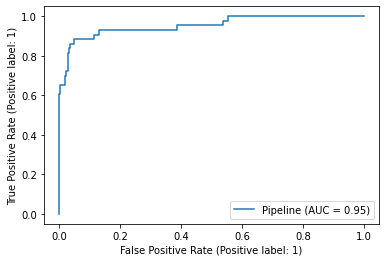

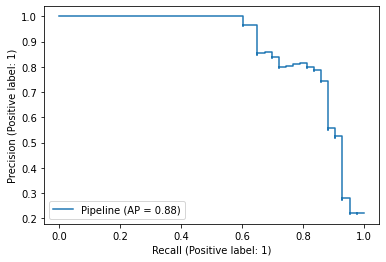

In [ ]:
# https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

# Load data
[X_train, X_test, y_train] = load_data()

numeric_features = list(X_train.select_dtypes(include=['int64', 'float64']))
X_train = min_max_scaling(X_train, numeric_features)
X_test = min_max_scaling(X_test, numeric_features)

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classification', SVC(probability=True, random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 0.99, 'majority'],
            'classification__C': [0.1, 1, 10, 100, 1000],
            'classification__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
            'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/SVMUndersampling.csv", index=None)


------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------
Best: 0.868979 using {'classification__C': 10, 'classification__gamma': 0.1, 'classification__kernel': 'rbf'}
----------------- Metrics: -----------------
Mean Fit Time: 0.04614121913909912
Mean Score Time: 0.027037396669387818
Mean Accuracy Score: 0.7263565188172043
Mean Precision Score: 0.3370589583655258
Mean Recall Score: 0.7957333333333333
Mean Roc-Auc Score: 0.8384342813051147
Mean F1 Score: 0.45714686109051716


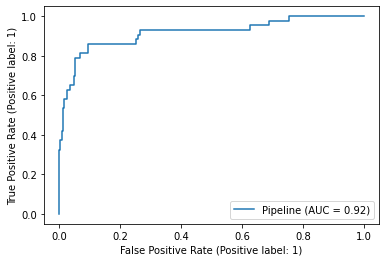

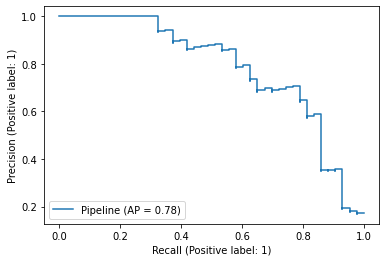

In [ ]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")

clf = Pipeline([('classification', SVC(probability=True, random_state=0))])

param_grid = {'classification__C': [0.1, 1, 10, 100, 1000],
              'classification__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'classification__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/SVM.csv", index=None)

In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classification', SVC(probability=True, random_state=0))])

weights = list(np.linspace(0.2, 0.9, 10)) + ['minority', 'auto']
param_grid['smote__sampling_strategy'] = weights

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/SVMWithSMOTE.csv", index=None)

# Light GBM

In [6]:
# Load data
[X_train, X_test, y_train] = load_data()

# With Undersampling
print("------- WITH UNDERSAMPLING -------")
pipeline = Pipeline([('under', RandomUnderSampler(random_state=0)), ('classifier', lgb.LGBMClassifier(random_state=0))])

param_grid = {'under__sampling_strategy': [0.2, 0.25, 0.5, 0.75, 0.9, 'majority'],
              'classifier__max_depth': [25, 50, 75],
              'classifier__learning_rate' : [0.01, 0.05, 0.1],
              'classifier__num_leaves': [int(x) for x in range(2, 100, 50)],
              'classifier__n_estimators': [int(x) for x in range(10, 200, 50)],
             }

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/lightGBMUndersampling.csv", index=None)

------- WITH UNDERSAMPLING -------


KeyboardInterrupt: 

In [ ]:
# Without Oversampling & Undersampling
print("------- WITHOUT OVERSAMPLING & UNDERSAMPLING -------")
pipeline = Pipeline([('classifier', lgb.LGBMClassifier(random_state=0))])

param_grid = {'classifier__max_depth': [25, 50, 75],
              'classifier__learning_rate' : [0.01, 0.05, 0.1],
              'classifier__num_leaves': [int(x) for x in range(2, 100, 25)],
              'classifier__n_estimators': [int(x) for x in range(2, 200, 25)],
              'classifier__colsample_bytree': [0.65, 0.75, 0.8, 1.0]
             }

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/SVMUndersampling.csv", index=None)

In [ ]:
# With Oversampling
print("------- WITH OVERSAMPLING -------")
pipeline = Pipeline([('smote', SMOTE(random_state=0)), ('classifier', lgb.LGBMClassifier(random_state=0))])

weights = list(np.linspace(0.2, 0.9, 10)) + ['minority', 'auto']
param_grid['smote__sampling_strategy'] = weights

results_df = run_model(pipeline, param_grid, X_train, y_train, X_test)
results_df.to_csv("./results/SVMWithSMOTE.csv", index=None)

# Histograms for all algorithms